In [1]:
from concerto.utils import universal_model
from cobra.flux_analysis.gapfilling import gapfill
from memote.experimental.config import ExperimentConfiguration
from concerto.utils.gene_essentiality import create_ge_confusion_matrix


Set parameter Username
Set parameter GURO_PAR_SPECIAL
Set parameter TokenServer to value "leghorn"


In [ ]:
from syn_elong import model, exp_file_path as syn_pathfrom
from syn_elong.media import m9_media, syn_min_media

In [28]:
import matplotlib.pyplot as plt

In [3]:
model.medium = m9_media

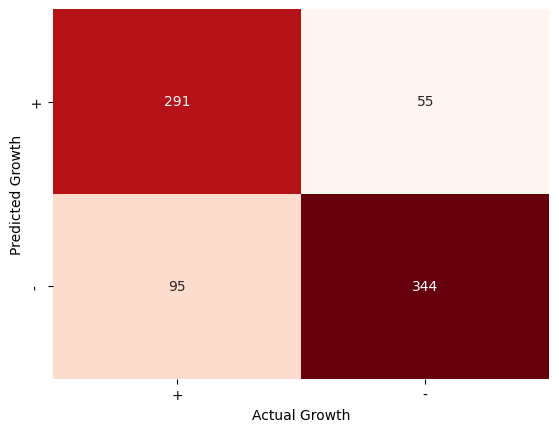

In [29]:
results = create_ge_confusion_matrix(model, syn_pathfrom)
plt.savefig("before_gapfill.png")

In [9]:
results['FP'].index.values

array(['SYNPCC7942_RS00005', 'SYNPCC7942_RS00015', 'SYNPCC7942_RS00345',
       'SYNPCC7942_RS00575', 'SYNPCC7942_RS00685', 'SYNPCC7942_RS00790',
       'SYNPCC7942_RS00985', 'SYNPCC7942_RS01045', 'SYNPCC7942_RS01140',
       'SYNPCC7942_RS01500', 'SYNPCC7942_RS01505', 'SYNPCC7942_RS01750',
       'SYNPCC7942_RS01885', 'SYNPCC7942_RS02010', 'SYNPCC7942_RS02075',
       'SYNPCC7942_RS02165', 'SYNPCC7942_RS02185', 'SYNPCC7942_RS02255',
       'SYNPCC7942_RS13675', 'SYNPCC7942_RS02490', 'SYNPCC7942_RS02765',
       'SYNPCC7942_RS02940', 'SYNPCC7942_RS02945', 'SYNPCC7942_RS03055',
       'SYNPCC7942_RS03095', 'SYNPCC7942_RS03120', 'SYNPCC7942_RS03225',
       'SYNPCC7942_RS03355', 'SYNPCC7942_RS03380', 'SYNPCC7942_RS03485',
       'SYNPCC7942_RS03570', 'SYNPCC7942_RS04180', 'SYNPCC7942_RS04290',
       'SYNPCC7942_RS04440', 'SYNPCC7942_RS04735', 'SYNPCC7942_RS04750',
       'SYNPCC7942_RS04830', 'SYNPCC7942_RS04890', 'SYNPCC7942_RS05155',
       'SYNPCC7942_RS05285', 'SYNPCC7942_RS05330', 

In [14]:
def find_rxns(model, universal_model, gene):
    with model:
        model.genes.get_by_id(gene).knock_out()
        try:
            result = gapfill(
                model, 
                universal_model,
                demand_reactions=False, 
                exchange_reactions =False,
                iterations=4
            )
            for i, entries in enumerate(result):
                print("---- Run %d ----" % (i + 1))
                for e in entries:
                    print(e.id)
        except:
            print(f'{gene} no go')
            return [{gene:None}]
    return [{gene:result}]

rxns = []
for gene in results['FP'].index.values:
    rxns += find_rxns(model, universal_model, gene)
    

Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpd869hr6d.lp
Reading time = 0.01 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmppzjhxdg4.lp
Reading time = 0.18 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS00005 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpb9_41qax.lp
Reading time = 0.02 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpnlfrd2e3.lp
Reading time = 0.22 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
---- Run 1 ----
PRFGS_1
---- Run 2 ----
PRFGS_1
---- Run 3 ----
PRFGS_1
---- Run 4 ----
PRFGS_1
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpf7qyo1kt.lp
Reading time = 0.01 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpxfkroc52.lp
Reading time = 0.15 seconds
: 15638 r

Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpbyo8cw25.lp
Reading time = 0.25 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS02940 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpyximhkge.lp
Reading time = 0.01 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmptgiw49fp.lp
Reading time = 0.22 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS02945 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp4yyxk8hg.lp
Reading time = 0.02 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpjmmuhu2b.lp
Reading time = 0.23 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS03055 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp0z2dgjti.lp
Reading time = 0.01 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP fo

---- Run 1 ----
FASC161ACP
GLYOX_2
---- Run 2 ----
AACPS4
HDECH
---- Run 3 ----
SUCptspp_1
C161SN
---- Run 4 ----
PYDXO
PDYXPT_c
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp7rn928k_.lp
Reading time = 0.01 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpgcs5t9ba.lp
Reading time = 0.18 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS06065 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpgtdae56r.lp
Reading time = 0.02 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp1vxrsqwh.lp
Reading time = 0.17 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS06375 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpzddleflb.lp
Reading time = 0.01 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local

Reading time = 0.02 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpgqqj0nqo.lp
Reading time = 0.28 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS09645 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpxd8o_ha3.lp
Reading time = 0.03 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp1rt6cm62.lp
Reading time = 0.31 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS09650 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpt5n7zl49.lp
Reading time = 0.02 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp72pzmulv.lp
Reading time = 0.27 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
---- Run 1 ----
FRDO
---- Run 2 ----
GLYOX_2
---- Run 3 ----
GLGB
---- Run 4 ----
SUCptspp_1
Read LP format model fro

Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpkj0tm18s.lp
Reading time = 0.40 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
---- Run 1 ----
FASC161ACP
GLYOX_2
---- Run 2 ----
AACPS4
HDECH
---- Run 3 ----
SUCptspp_1
C161SN
---- Run 4 ----
PYDXO
PDYXPT_c
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpj12z2ec3.lp
Reading time = 0.03 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp5ce783ww.lp
Reading time = 0.31 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
SYNPCC7942_RS12670 no go
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmp_wv86lhq.lp
Reading time = 0.02 seconds
: 884 rows, 1936 columns, 7886 nonzeros
Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmps9wgjwdu.lp
Reading time = 0.33 seconds
: 15638 rows, 56602 columns, 243784 nonzeros
---- Run 1 ----
APSR
---- Run 2 ----
APSR
---- Run 3 ----
GRXR
APSR2
---- Run 4 -

In [15]:
rxns

[{'SYNPCC7942_RS00005': None},
 {'SYNPCC7942_RS00015': [[<Reaction PRFGS_1 at 0x22da4b72170>],
   [<Reaction PRFGS_1 at 0x22da4b72170>],
   [<Reaction PRFGS_1 at 0x22da4b72170>],
   [<Reaction PRFGS_1 at 0x22da4b72170>]]},
 {'SYNPCC7942_RS00345': None},
 {'SYNPCC7942_RS00575': [[<Reaction GLGB at 0x22dd0784a60>],
   [<Reaction SUCptspp_1 at 0x22dcf5cb2b0>],
   [<Reaction FPRA at 0x22dd0784880>],
   [<Reaction GLYOX_2 at 0x22dd0060b50>]]},
 {'SYNPCC7942_RS00685': None},
 {'SYNPCC7942_RS00790': [[<Reaction UGP_PGM_c at 0x22dfc6e55a0>],
   [<Reaction UGP_PGM_c at 0x22dfc6e55a0>],
   [<Reaction SUCptspp_1 at 0x22dfc2294e0>, <Reaction SUCP at 0x22dfe383310>],
   [<Reaction UGP_PGM_c at 0x22dfc6e55a0>]]},
 {'SYNPCC7942_RS00985': None},
 {'SYNPCC7942_RS01045': None},
 {'SYNPCC7942_RS01140': [[<Reaction FASC161ACP at 0x22dfc4d1000>,
    <Reaction GLYOX_2 at 0x22e3fefa050>],
   [<Reaction AACPS4 at 0x22e3d98fd00>, <Reaction HDECH at 0x22e40625210>],
   [<Reaction SUCptspp_1 at 0x22de64f87f0>,
 

In [23]:
rxns_to_add = set()
for i in rxns:
#     print(i)
    for gene, rxn in i.items():
        if rxn is not None:
            good_rxns = [j.id for j in rxn[0]]
            print(gene, good_rxns)
            rxns_to_add.update(good_rxns)

SYNPCC7942_RS00015 ['PRFGS_1']
SYNPCC7942_RS00575 ['GLGB']
SYNPCC7942_RS00790 ['UGP_PGM_c']
SYNPCC7942_RS01140 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS01500 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS01505 ['SADT2']
SYNPCC7942_RS01750 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS01885 ['AHSERL2']
SYNPCC7942_RS02010 ['CDPDAGS1819Z160']
SYNPCC7942_RS02075 ['FRDO']
SYNPCC7942_RS02165 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS02255 ['AIRC1']
SYNPCC7942_RS13675 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS03095 ['GLCS2']
SYNPCC7942_RS03355 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS03380 ['PPND2']
SYNPCC7942_RS03570 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS04290 ['ASNTRS_1']
SYNPCC7942_RS04735 ['FRDO']
SYNPCC7942_RS04830 ['PAPSSH']
SYNPCC7942_RS05285 ['ILETA2', 'aratyr1']
SYNPCC7942_RS05330 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS13745 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS06405 ['FRDO']
SYNPCC7942_RS06760 ['FRDO']
Synpcc7942_1478 ['GLGB']
SYNPCC7942_RS08350 ['FASC161ACP', 'GLYOX_2']
SYNPCC7942_RS08550 ['FASC161ACP'

In [1]:
len(rxns_to_add)

NameError: name 'rxns_to_add' is not defined

In [37]:
with open('rxns_to_add_for_ge.txt', 'w') as f:
    for i in rxns_to_add:
        f.writelines(i+'\n')
        print(i)
        print(universal_model.reactions.get_by_id(i))

GLCS1
GLCS1: adpglc_c --> adp_c + glycogen_c + h_c
SADT2
SADT2: atp_c + gtp_c + h2o_c + so4_c --> aps_c + gdp_c + pi_c + ppi_c
ATPSu
ATPSu: 3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c + 3.0 h2o_c + 11.0 h_c
PPND2
PPND2: nadp_c + pphn_c --> 34hpp_c + co2_c + nadph_c
aratyr1
aratyr1: 4mop_c + tyr__L_c --> 34hpp_c + leu__L_c
CDPDAGS1819Z160
CDPDAGS1819Z160: ctp_c + 3.0 h_c + pa1819Z160_c --> cdp12dgr1819Z160_c + ppi_c
ASNTRS_1
ASNTRS_1: asn__L_c + atp_c + trnaasn_c --> amp_c + asntrna_c + h_c + ppi_c
GLGB
GLGB: 14glucan_c --> glycogen_c
FRDO
FRDO: fdxrd_c + nadp_c --> fdxox_c + h_c + nadph_c
ACGAM6PS
ACGAM6PS: accoa_c + gam6p_c --> acgam6p_c + coa_c + h_c
PGPS1819Z160
PGPS1819Z160: cdp12dgr1819Z160_c + glyc3p_c --> cmp_c + pgp1819Z160_c
PAPSSH
PAPSSH: 2.0 h_c + pap_c + so4_c --> h2o_c + paps_c
GLYOX_2
GLYOX_2: h2o_c + lgt__S_c --> gthrd_c + h_c + lac__D_c + mthgxl_c
APSR
APSR: aps_c + trdrd_c --> amp_c + 2.0 h_c + so3_c + trdox_c
AIRC1
AIRC1: air_c + atp_c + co2_c + h2o_c --> 5aizc_c + 

In [ ]:
actual_rxns = [universal_model.reactions.get_by_id(i) for i in rxns_to_add]

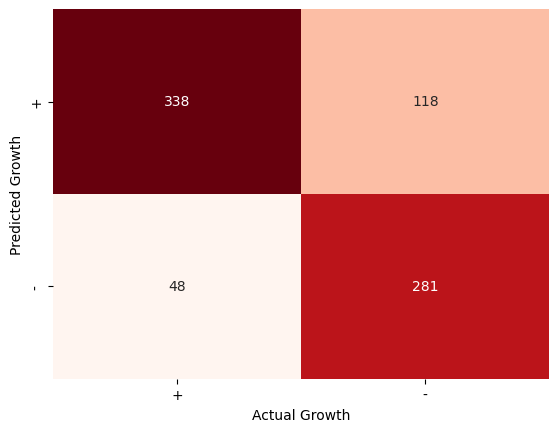

In [30]:
with model:
    model.add_reactions(actual_rxns)
    create_ge_confusion_matrix(model, syn_pathfrom)
    plt.savefig("after_gapfill.png")

In [ ]:
results = create_ge_confusion_matrix(model, syn_pathfrom)